In [2]:
import pandas as pd
import os

In [3]:
from datetime import timedelta
import math

# extract N time windows from the video
def trim(video, _df):
    """
        Masks the dataframe by the time both the speakers arrive
    """
    transcript = pd.read_csv(f'all_videos/{video}/transcription/transcript_cliffhanger.csv')
    i = 0
    start = 0

    # sometimes the first person to arrive speaks but there is nobody
    while True:
        start1 = math.floor(transcript['start'].values[i])
        start2 = math.floor(transcript['start'].values[i+1])
        
        # check if there is a response to the first utterance in less than 5s
        if start2-start1 < 5:
            start = start1
            break
        else:
            i+=1
    stop = math.ceil(transcript['stop'].values[-1])

    # mask the rows
    df = _df.copy()
    df['seconds'] = [pd.Timedelta(value).seconds for value in df['timedelta']]
    mask = (df['seconds'] >= start) & (df['seconds'] <= stop)
    selected_rows = df[mask]

    return selected_rows, start, stop


In [4]:
# data opening
videos = os.listdir('./all_videos/')
full_dfs = []

OFFSET_SIZE = 3 * 60
WINDOW_SIZE = 3 * 60

head_bob = []
head_joe = []

tail_bob = []
tail_joe = []

for video in videos:
    f_features = open(f'./all_videos/{video}/audio_video_features.csv', 'r')
    df = pd.read_csv(f_features)

    # make it more readable
    username1 = df['user_id'].unique()[0]
    username2 = df['user_id'].unique()[1]

    df['user_id'] = df['user_id'].replace(username1, "Bob")
    df['user_id'] = df['user_id'].replace(username2, "Joe")

    df, start, stop = trim(video, df)
    window1 = df[df['seconds'] <= start+OFFSET_SIZE+WINDOW_SIZE] 
    window2 = df[df['seconds'] >= stop-OFFSET_SIZE-WINDOW_SIZE]
    
    # count how much people talk in first window
    head_joe_talks = len(window1[(window1['user_id']=='Joe') & (window1['is_speaking']==True)].values)
    head_bob_talks = len(window1[(window1['user_id']=='Bob') & (window1['is_speaking']==True)].values)

    # count how much people talk in last window
    tail_joe_talks = len(window2[(window2['user_id']=='Joe') & (window2['is_speaking']==True)].values)
    tail_bob_talks = len(window2[(window2['user_id']=='Bob') & (window2['is_speaking']==True)].values)

    head_bob.append(head_bob_talks)
    head_joe.append(head_joe_talks)
    tail_bob.append(tail_bob_talks)
    tail_joe.append(tail_joe_talks)
    
    print(f"In video {video}, HEAD: bob {head_bob_talks} joe: bob {head_joe_talks}")
    print(f"In video {video}, TAIL: bob {tail_bob_talks} joe: bob {tail_joe_talks}")
    print('\n')

    # append the datasets    

In video 14e34c4e-4e27-42d8-928f-ad4a71f80764, HEAD: bob 239 joe: bob 237
In video 14e34c4e-4e27-42d8-928f-ad4a71f80764, TAIL: bob 211 joe: bob 251


In video 67836c1d-1334-41a0-a33a-4f788e8b6fb3, HEAD: bob 266 joe: bob 158
In video 67836c1d-1334-41a0-a33a-4f788e8b6fb3, TAIL: bob 204 joe: bob 203


In video dea8799a-4d4c-432a-8694-0a92029d90b9, HEAD: bob 248 joe: bob 264
In video dea8799a-4d4c-432a-8694-0a92029d90b9, TAIL: bob 237 joe: bob 269


In video 7f717277-d9ae-4dbc-b520-0b741d91a6c7, HEAD: bob 310 joe: bob 148
In video 7f717277-d9ae-4dbc-b520-0b741d91a6c7, TAIL: bob 310 joe: bob 186


In video 167471c0-9faf-4d4d-b9c3-291e859d3dcd, HEAD: bob 180 joe: bob 267
In video 167471c0-9faf-4d4d-b9c3-291e859d3dcd, TAIL: bob 271 joe: bob 210


In video a29635a0-d33c-4ddd-ba70-154170b85057, HEAD: bob 182 joe: bob 288
In video a29635a0-d33c-4ddd-ba70-154170b85057, TAIL: bob 208 joe: bob 265


In video eb215077-bbb6-45ee-923f-345783358eee, HEAD: bob 179 joe: bob 242
In video eb215077-bbb6-45e

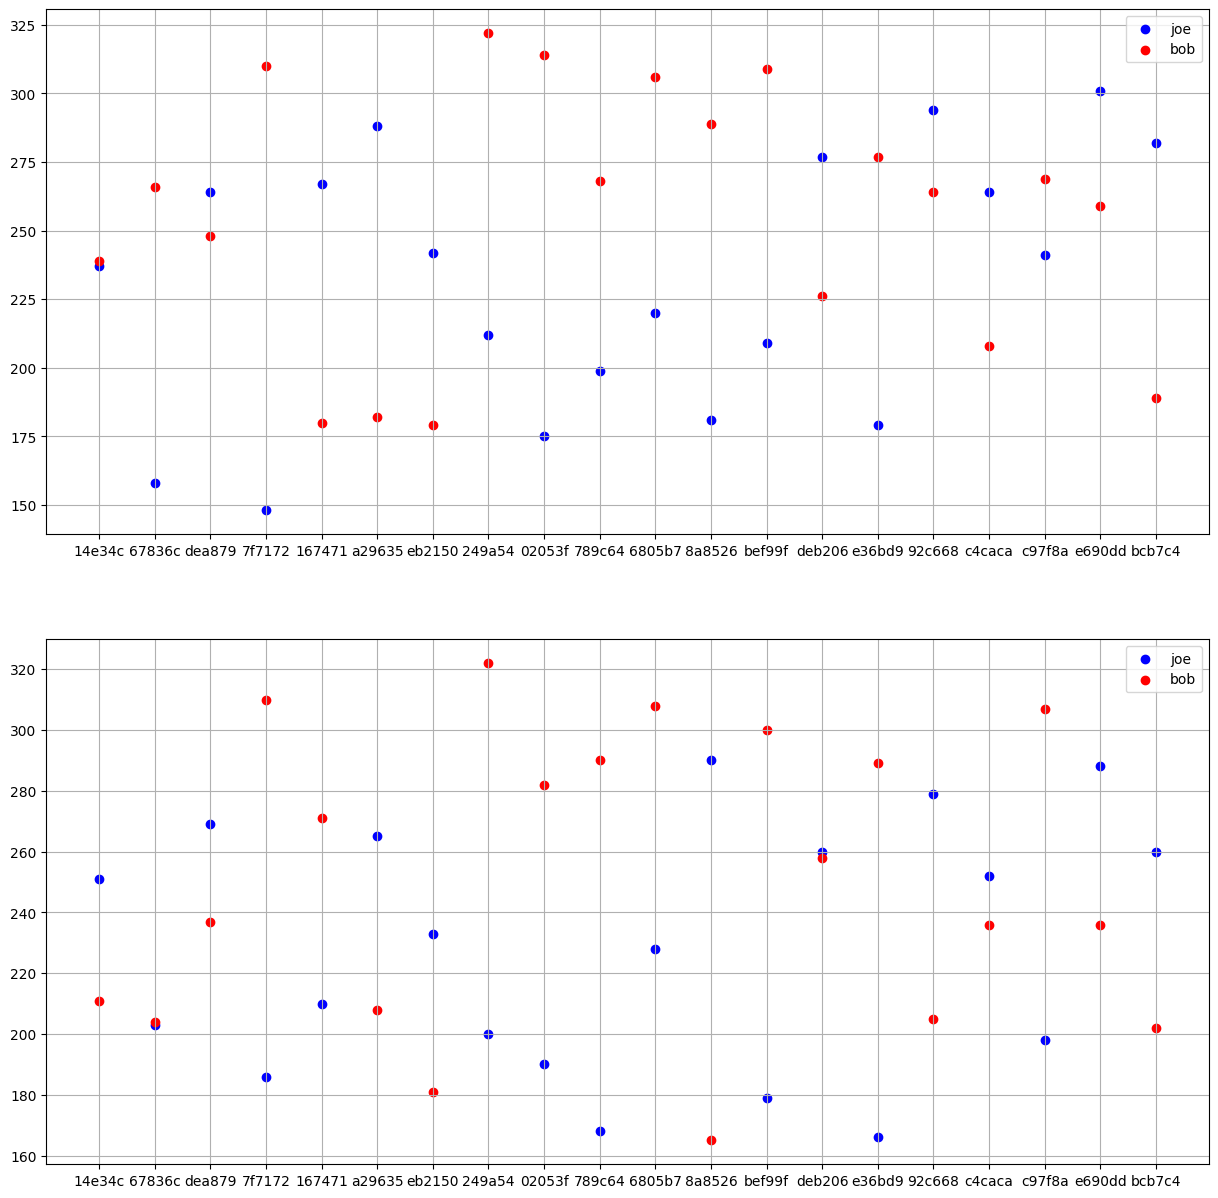

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, axs = plt.subplots(2, figsize=(15,15))

x = np.linspace(0, len(videos), len(videos))

_videos = [video[:6] for video in videos]

# head
axs[0].scatter(_videos, head_joe, c="b", label="joe")
axs[0].scatter(_videos, head_bob, c="r", label="bob")
axs[0].legend()
axs[0].grid()


# tail
axs[1].scatter(_videos, tail_joe, c="b", label="joe")
axs[1].scatter(_videos, tail_bob, c="r", label="bob")
axs[1].grid()
axs[1].legend()

14e34c4e-4e27-42d8-928f-ad4a71f80764
dea8799a-4d4c-432a-8694-0a92029d90b9
c4caca36-1ace-44de-844a-0933eface36a
e690dd3f-9308-41df-aa46-7979ddd87caf


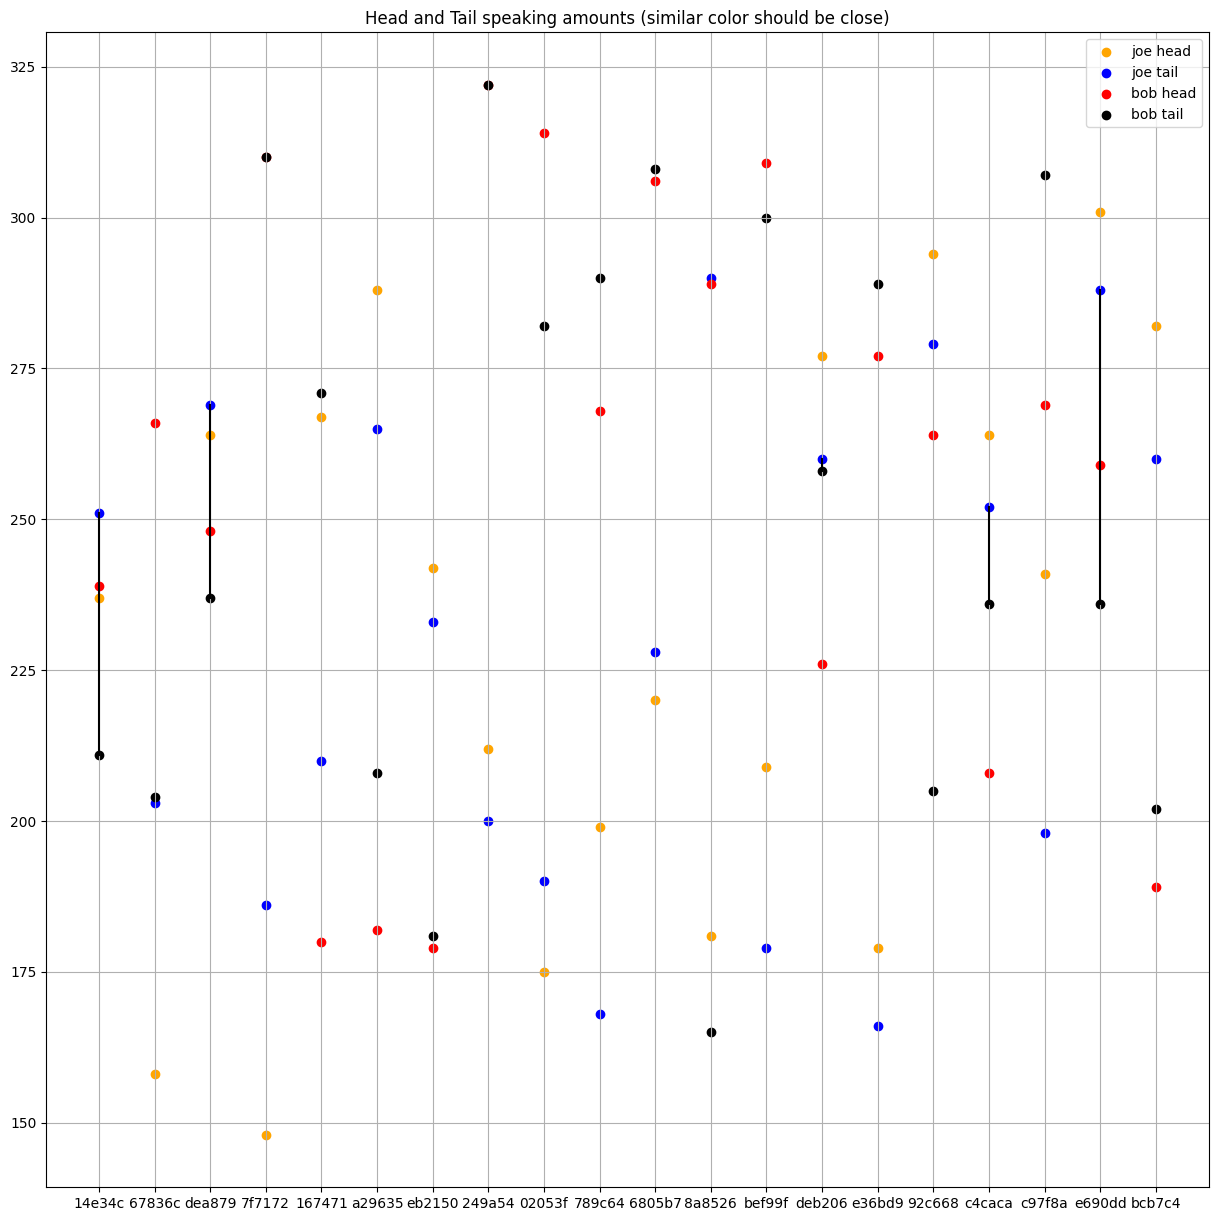

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, axs = plt.subplots(1, figsize=(15,15))

x = np.linspace(0, len(videos), len(videos))

_videos = [video[:6] for video in videos]

# tail is darker
axs.scatter(_videos, head_joe, c="orange", label="joe head")
axs.scatter(_videos, tail_joe, c="blue", label="joe tail")

axs.scatter(_videos, head_bob, c="red", label="bob head")
axs.scatter(_videos, tail_bob, c="black", label="bob tail")

for i in range(len(videos)):
    if abs(tail_joe[i] - tail_bob[i]) < 60:
        if abs(head_joe[i] - head_bob[i]) < 60:
            axs.plot([_videos[i], _videos[i]], [tail_joe[i], tail_bob[i]], color='black')
    # if :
    #     axs.plot([_videos[i], _videos[i]], [head_joe[i], head_bob[i]], color='red')

axs.legend()
axs.grid()
axs.set_title('Head and Tail speaking amounts (similar color should be close)')
print(videos[0])
print(videos[2])
print(videos[16])
print(videos[18])